<a href="https://colab.research.google.com/github/Malvi-M/Topic-Modelling-on-Covid-Vaccine-Tweets/blob/main/Topic_Modelling_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Overall Dataset**

In [ ]:
## importing libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
## importing dataset
df = pd.read_csv("/content/drive/MyDrive/NLP_Project/Vaccine_Sentiments.csv", quotechar='"', delimiter=',', index_col = 0)
df.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.



(159306, 16)

In [ ]:
! pip install vaderSentiment

     |████████████████████████████████| 133kB 5.3MB/s 


In [ ]:
import nltk
from nltk.corpus import stopwords, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import collections
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from stop_words_list import stop_words_list
#from wn_affect import wn_affect 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
df.date.max()

'2021-04-27'

In [ ]:
## tokenise string

df['tokenise'] = df.apply(lambda row: nltk.word_tokenize(row[13]), axis=1)
display(df.head())

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,sentiment,sentiment score,tokenise
880,AJ Love,United States,How is today a reflection of yesterday's life ...,13-03-2020 08:20,15.0,145.0,1268.0,False,2020-12-08,"They removed the #CFO #chiefFinancialOfficer, ...","['CFO', 'chiefFinancialOfficer', 'moneytransfe...",Twitter for Android,False,they removed the cfo chieffinancialofficer i w...,Neutral,0.0000,"[they, removed, the, cfo, chieffinancialoffice..."
881,Darkly Dangerous,United States,#sexualassaultsurvivor! \na southern belle wit...,12-10-2013 16:15,312.0,1730.0,1767.0,False,2020-12-08,The ones trusting #Gates &amp; #Fauci &amp; fo...,"['Gates', 'Fauci']",Twitter for Android,False,the ones trusting gates amp fauci amp for mand...,Positive,0.6808,"[the, ones, trusting, gates, amp, fauci, amp, ..."
882,Thailand Medical News,Thailand,A trusted source for all your medical and life...,06-11-2018 13:04,2231.0,1.0,2772.0,False,2020-12-08,COVID-19 Vaccine: Washington University’s Gene...,NaN,Twitter Web App,False,covid 19 vaccine washington university s genet...,Positive,0.3182,"[covid, 19, vaccine, washington, university, s..."
883,Ashwani Kumar | अश्वनी कुमार | 🇮🇳,India,"Believer, Optimist and a Passionate Adventure ...",31-07-2015 06:01,44.0,135.0,170.0,False,2020-12-08,Putin's daughter vaccinated with the first app...,NaN,Twitter for Android,False,putin s daughter vaccinated with the first app...,Positive,0.4215,"[putin, s, daughter, vaccinated, with, the, fi..."
884,Ashwani Kumar | अश्वनी कुमार | 🇮🇳,India,"Believer, Optimist and a Passionate Adventure ...",31-07-2015 06:01,44.0,135.0,170.0,False,2020-12-08,@MarketWatch Putin's daughter vaccinated with ...,NaN,Twitter for Android,False,putin s daughter vaccinated with the 1st appr...,Positive,0.4215,"[putin, s, daughter, vaccinated, with, the, 1s..."


In [ ]:
## initiate stopwords from nltk
stop_words = stopwords.words('english')

## add additional missing terms
stop_words.extend(stop_words_list) 
stop_words.extend(['johnson', 'johnson johnson', 'day', 'today', 'week', 'parisolympics'])
## remove stopwords

df['remove_stopwords'] = df['tokenise'].apply(lambda x: [item for item in x if item not in stop_words])
display(df.head())

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,sentiment,sentiment score,tokenise,remove_stopwords
880,AJ Love,United States,How is today a reflection of yesterday's life ...,13-03-2020 08:20,15.0,145.0,1268.0,False,2020-12-08,"They removed the #CFO #chiefFinancialOfficer, ...","['CFO', 'chiefFinancialOfficer', 'moneytransfe...",Twitter for Android,False,they removed the cfo chieffinancialofficer i w...,Neutral,0.0000,"[they, removed, the, cfo, chieffinancialoffice...","[removed, cfo, chieffinancialofficer, wonder, ..."
881,Darkly Dangerous,United States,#sexualassaultsurvivor! \na southern belle wit...,12-10-2013 16:15,312.0,1730.0,1767.0,False,2020-12-08,The ones trusting #Gates &amp; #Fauci &amp; fo...,"['Gates', 'Fauci']",Twitter for Android,False,the ones trusting gates amp fauci amp for mand...,Positive,0.6808,"[the, ones, trusting, gates, amp, fauci, amp, ...","[trusting, gates, fauci, mandates, yall, bette..."
882,Thailand Medical News,Thailand,A trusted source for all your medical and life...,06-11-2018 13:04,2231.0,1.0,2772.0,False,2020-12-08,COVID-19 Vaccine: Washington University’s Gene...,NaN,Twitter Web App,False,covid 19 vaccine washington university s genet...,Positive,0.3182,"[covid, 19, vaccine, washington, university, s...","[19, washington, university, genetically, modi..."
883,Ashwani Kumar | अश्वनी कुमार | 🇮🇳,India,"Believer, Optimist and a Passionate Adventure ...",31-07-2015 06:01,44.0,135.0,170.0,False,2020-12-08,Putin's daughter vaccinated with the first app...,NaN,Twitter for Android,False,putin s daughter vaccinated with the first app...,Positive,0.4215,"[putin, s, daughter, vaccinated, with, the, fi...","[putin, daughter, vaccinated, approved, planet..."
884,Ashwani Kumar | अश्वनी कुमार | 🇮🇳,India,"Believer, Optimist and a Passionate Adventure ...",31-07-2015 06:01,44.0,135.0,170.0,False,2020-12-08,@MarketWatch Putin's daughter vaccinated with ...,NaN,Twitter for Android,False,putin s daughter vaccinated with the 1st appr...,Positive,0.4215,"[putin, s, daughter, vaccinated, with, the, 1s...","[putin, daughter, vaccinated, 1st, approved, p..."


In [ ]:
## POS tagging

df["postags"] = df['remove_stopwords'].apply(lambda row: nltk.pos_tag(row))
display(df.head())

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,sentiment,sentiment score,tokenise,remove_stopwords,postags
880,AJ Love,United States,How is today a reflection of yesterday's life ...,13-03-2020 08:20,15.0,145.0,1268.0,False,2020-12-08,"They removed the #CFO #chiefFinancialOfficer, ...","['CFO', 'chiefFinancialOfficer', 'moneytransfe...",Twitter for Android,False,they removed the cfo chieffinancialofficer i w...,Neutral,0.0000,"[they, removed, the, cfo, chieffinancialoffice...","[removed, cfo, chieffinancialofficer, wonder, ...","[(removed, VBN), (cfo, JJ), (chieffinancialoff..."
881,Darkly Dangerous,United States,#sexualassaultsurvivor! \na southern belle wit...,12-10-2013 16:15,312.0,1730.0,1767.0,False,2020-12-08,The ones trusting #Gates &amp; #Fauci &amp; fo...,"['Gates', 'Fauci']",Twitter for Android,False,the ones trusting gates amp fauci amp for mand...,Positive,0.6808,"[the, ones, trusting, gates, amp, fauci, amp, ...","[trusting, gates, fauci, mandates, yall, bette...","[(trusting, VBG), (gates, NNS), (fauci, VBP), ..."
882,Thailand Medical News,Thailand,A trusted source for all your medical and life...,06-11-2018 13:04,2231.0,1.0,2772.0,False,2020-12-08,COVID-19 Vaccine: Washington University’s Gene...,NaN,Twitter Web App,False,covid 19 vaccine washington university s genet...,Positive,0.3182,"[covid, 19, vaccine, washington, university, s...","[19, washington, university, genetically, modi...","[(19, CD), (washington, NN), (university, NN),..."
883,Ashwani Kumar | अश्वनी कुमार | 🇮🇳,India,"Believer, Optimist and a Passionate Adventure ...",31-07-2015 06:01,44.0,135.0,170.0,False,2020-12-08,Putin's daughter vaccinated with the first app...,NaN,Twitter for Android,False,putin s daughter vaccinated with the first app...,Positive,0.4215,"[putin, s, daughter, vaccinated, with, the, fi...","[putin, daughter, vaccinated, approved, planet...","[(putin, NN), (daughter, NN), (vaccinated, VBD..."
884,Ashwani Kumar | अश्वनी कुमार | 🇮🇳,India,"Believer, Optimist and a Passionate Adventure ...",31-07-2015 06:01,44.0,135.0,170.0,False,2020-12-08,@MarketWatch Putin's daughter vaccinated with ...,NaN,Twitter for Android,False,putin s daughter vaccinated with the 1st appr...,Positive,0.4215,"[putin, s, daughter, vaccinated, with, the, 1s...","[putin, daughter, vaccinated, 1st, approved, p...","[(putin, NN), (daughter, NN), (vaccinated, VBD..."


In [ ]:
## extracting only nouns and verbs for effective topic modelling

def extract_words(row):
    postags = row["postags"]
    words = list()
    for word in postags:
      if (word[1] in ['NN', 'NNS', 'NNP', 'NNPS', 'UH', 'VB', 'VBG', 'VBD']):
        words.append(word[0])
    return words

df["req_words"] = df.apply(lambda row: extract_words(row), axis = 1)
display(df.head())

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,sentiment,sentiment score,tokenise,remove_stopwords,postags,req_words
880,AJ Love,United States,How is today a reflection of yesterday's life ...,13-03-2020 08:20,15.0,145.0,1268.0,False,2020-12-08,"They removed the #CFO #chiefFinancialOfficer, ...","['CFO', 'chiefFinancialOfficer', 'moneytransfe...",Twitter for Android,False,they removed the cfo chieffinancialofficer i w...,Neutral,0.0000,"[they, removed, the, cfo, chieffinancialoffice...","[removed, cfo, chieffinancialofficer, wonder, ...","[(removed, VBN), (cfo, JJ), (chieffinancialoff...","[chieffinancialofficer, wonder, making, moneyt..."
881,Darkly Dangerous,United States,#sexualassaultsurvivor! \na southern belle wit...,12-10-2013 16:15,312.0,1730.0,1767.0,False,2020-12-08,The ones trusting #Gates &amp; #Fauci &amp; fo...,"['Gates', 'Fauci']",Twitter for Android,False,the ones trusting gates amp fauci amp for mand...,Positive,0.6808,"[the, ones, trusting, gates, amp, fauci, amp, ...","[trusting, gates, fauci, mandates, yall, bette...","[(trusting, VBG), (gates, NNS), (fauci, VBP), ...","[trusting, gates, mandates, sacrifice]"
882,Thailand Medical News,Thailand,A trusted source for all your medical and life...,06-11-2018 13:04,2231.0,1.0,2772.0,False,2020-12-08,COVID-19 Vaccine: Washington University’s Gene...,NaN,Twitter Web App,False,covid 19 vaccine washington university s genet...,Positive,0.3182,"[covid, 19, vaccine, washington, university, s...","[19, washington, university, genetically, modi...","[(19, CD), (washington, NN), (university, NN),...","[washington, university, virus, promise, mice,..."
883,Ashwani Kumar | अश्वनी कुमार | 🇮🇳,India,"Believer, Optimist and a Passionate Adventure ...",31-07-2015 06:01,44.0,135.0,170.0,False,2020-12-08,Putin's daughter vaccinated with the first app...,NaN,Twitter for Android,False,putin s daughter vaccinated with the first app...,Positive,0.4215,"[putin, s, daughter, vaccinated, with, the, fi...","[putin, daughter, vaccinated, approved, planet...","[(putin, NN), (daughter, NN), (vaccinated, VBD...","[putin, daughter, vaccinated, reason, question]"
884,Ashwani Kumar | अश्वनी कुमार | 🇮🇳,India,"Believer, Optimist and a Passionate Adventure ...",31-07-2015 06:01,44.0,135.0,170.0,False,2020-12-08,@MarketWatch Putin's daughter vaccinated with ...,NaN,Twitter for Android,False,putin s daughter vaccinated with the 1st appr...,Positive,0.4215,"[putin, s, daughter, vaccinated, with, the, 1s...","[putin, daughter, vaccinated, 1st, approved, p...","[(putin, NN), (daughter, NN), (vaccinated, VBD...","[putin, daughter, vaccinated, planet, reason, qu]"


In [ ]:
##  lemmatise words

wordnet_lemmatizer = WordNetLemmatizer()
df['lemmatise'] = df['req_words'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) 
display(df.head(10))

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,sentiment,sentiment score,tokenise,remove_stopwords,postags,req_words,lemmatise
880,AJ Love,United States,How is today a reflection of yesterday's life ...,13-03-2020 08:20,15.0,145.0,1268.0,False,2020-12-08,"They removed the #CFO #chiefFinancialOfficer, ...","['CFO', 'chiefFinancialOfficer', 'moneytransfe...",Twitter for Android,False,they removed the cfo chieffinancialofficer i w...,Neutral,0.0000,"[they, removed, the, cfo, chieffinancialoffice...","[removed, cfo, chieffinancialofficer, wonder, ...","[(removed, VBN), (cfo, JJ), (chieffinancialoff...","[chieffinancialofficer, wonder, making, moneyt...","[chieffinancialofficer, wonder, making, moneyt..."
881,Darkly Dangerous,United States,#sexualassaultsurvivor! \na southern belle wit...,12-10-2013 16:15,312.0,1730.0,1767.0,False,2020-12-08,The ones trusting #Gates &amp; #Fauci &amp; fo...,"['Gates', 'Fauci']",Twitter for Android,False,the ones trusting gates amp fauci amp for mand...,Positive,0.6808,"[the, ones, trusting, gates, amp, fauci, amp, ...","[trusting, gates, fauci, mandates, yall, bette...","[(trusting, VBG), (gates, NNS), (fauci, VBP), ...","[trusting, gates, mandates, sacrifice]","[trusting, gate, mandate, sacrifice]"
882,Thailand Medical News,Thailand,A trusted source for all your medical and life...,06-11-2018 13:04,2231.0,1.0,2772.0,False,2020-12-08,COVID-19 Vaccine: Washington University’s Gene...,NaN,Twitter Web App,False,covid 19 vaccine washington university s genet...,Positive,0.3182,"[covid, 19, vaccine, washington, university, s...","[19, washington, university, genetically, modi...","[(19, CD), (washington, NN), (university, NN),...","[washington, university, virus, promise, mice,...","[washington, university, virus, promise, mouse..."
883,Ashwani Kumar | अश्वनी कुमार | 🇮🇳,India,"Believer, Optimist and a Passionate Adventure ...",31-07-2015 06:01,44.0,135.0,170.0,False,2020-12-08,Putin's daughter vaccinated with the first app...,NaN,Twitter for Android,False,putin s daughter vaccinated with the first app...,Positive,0.4215,"[putin, s, daughter, vaccinated, with, the, fi...","[putin, daughter, vaccinated, approved, planet...","[(putin, NN), (daughter, NN), (vaccinated, VBD...","[putin, daughter, vaccinated, reason, question]","[putin, daughter, vaccinated, reason, question]"
884,Ashwani Kumar | अश्वनी कुमार | 🇮🇳,India,"Believer, Optimist and a Passionate Adventure ...",31-07-2015 06:01,44.0,135.0,170.0,False,2020-12-08,@MarketWatch Putin's daughter vaccinated with ...,NaN,Twitter for Android,False,putin s daughter vaccinated with the 1st appr...,Positive,0.4215,"[putin, s, daughter, vaccinated, with, the, 1s...","[putin, daughter, vaccinated, 1st, approved, p...","[(putin, NN), (daughter, NN), (vaccinated, VBD...","[putin, daughter, vaccinated, planet, reason, qu]","[putin, daughter, vaccinated, planet, reason, qu]"
885,Ashwani Kumar | अश्वनी कुमार | 🇮🇳,India,"Believer, Optimist and a Passionate Adventure ...",31-07-2015 06:01,44.0,135.0,170.0,False,2020-12-08,@ABC @DebRobertsABC @NatGeo Putin's daughter v...,NaN,Twitter for Android,False,putin s daughter vaccinated with the 1st appr...,Positive,0.4215,"[putin, s, daughter, vaccinated, with, the, 1s...","[putin, daughter, vaccinated, 1st, approved, p...","[(putin, NN), (daughter, NN), (vaccinated, VBD...","[putin, daughter, vaccinated, planet]","[putin, daughter, vaccinated, planet]"
886,Ashwani Kumar | अश्वनी कुमार | 🇮🇳,India,"Believer, Optimist and a Passionate Adventure ...",31-07-2015 06:01,44.0,135.0,170.0,False,2020-12-08,@kylegriffin1 Putin's daughter vaccinated with...,NaN,Twitter for Android,False,putin s daughter vaccinated with the 1st appr...,Positive,0.4215,"[putin, s, daughter, vaccinated, with, the, 1s...","[putin, daughter, vaccinated, 1st, approved, p...","[(putin, NN), (daughter, NN), (vaccinated, VBD...","[putin, daughter, vac

In [ ]:
## count vectorizer 

vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
vectors = []

for index, row in df.iterrows():
    vectors.append(",".join(row[20]))

vectorised = vectorizer.fit_transform(vectors)

print(vectorised.shape)

(159306, 356569)


In [ ]:
## LDA Model

lda_model = LatentDirichletAllocation(n_components = 7, # number of topics
                                  random_state = 52,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(vectorised)

## column names

topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

##  get dominant topic for each document

dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes

df = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'left')
display(df.head())
print(df.shape)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,sentiment,sentiment score,tokenise,remove_stopwords,postags,req_words,lemmatise,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Dominant_topic
880,AJ Love,United States,How is today a reflection of yesterday's life ...,13-03-2020 08:20,15.0,145.0,1268.0,False,2020-12-08,"They removed the #CFO #chiefFinancialOfficer, ...","['CFO', 'chiefFinancialOfficer', 'moneytransfe...",Twitter for Android,False,they removed the cfo chieffinancialofficer i w...,Neutral,0.0000,"[they, removed, the, cfo, chieffinancialoffice...","[removed, cfo, chieffinancialofficer, wonder, ...","[(removed, VBN), (cfo, JJ), (chieffinancialoff...","[chieffinancialofficer, wonder, making, moneyt...","[chieffinancialofficer, wonder, making, moneyt...",0.04,0.79,0.04,0.04,0.04,0.04,0.04,2.0
881,Darkly Dangerous,United States,#sexualassaultsurvivor! \na southern belle wit...,12-10-2013 16:15,312.0,1730.0,1767.0,False,2020-12-08,The ones trusting #Gates &amp; #Fauci &amp; fo...,"['Gates', 'Fauci']",Twitter for Android,False,the ones trusting gates amp fauci amp for mand...,Positive,0.6808,"[the, ones, trusting, gates, amp, fauci, amp, ...","[trusting, gates, fauci, mandates, yall, bette...","[(trusting, VBG), (gates, NNS), (fauci, VBP), ...","[trusting, gates, mandates, sacrifice]","[trusting, gate, mandate, sacrifice]",0.07,0.07,0.07,0.07,0.07,0.07,0.57,7.0
882,Thailand Medical News,Thailand,A trusted source for all your medical and life...,06-11-2018 13:04,2231.0,1.0,2772.0,False,2020-12-08,COVID-19 Vaccine: Washington University’s Gene...,NaN,Twitter Web App,False,covid 19 vaccine washington university s genet...,Positive,0.3182,"[covid, 19, vaccine, washington, university, s...","[19, washington, university, genetically, modi...","[(19, CD), (washington, NN), (university, NN),...","[washington, university, virus, promise, mice,...","[washington, university, virus, promise, mouse...",0.02,0.02,0.02,0.02,0.02,0.02,0.89,7.0
883,Ashwani Kumar | अश्वनी कुमार | 🇮🇳,India,"Believer, Optimist and a Passionate Adventure ...",31-07-2015 06:01,44.0,135.0,170.0,False,2020-12-08,Putin's daughter vaccinated with the first app...,NaN,Twitter for Android,False,putin s daughter vaccinated with the first app...,Positive,0.4215,"[putin, s, daughter, vaccinated, with, the, fi...","[putin, daughter, vaccinated, approved, planet...","[(putin, NN), (daughter, NN), (vaccinated, VBD...","[putin, daughter, vaccinated, reason, question]","[putin, daughter, vaccinated, reason, question]",0.90,0.02,0.02,0.02,0.02,0.02,0.02,1.0
884,Ashwani Kumar | अश्वनी कुमार | 🇮🇳,India,"Believer, Optimist and a Passionate Adventure ...",31-07-2015 06:01,44.0,135.0,170.0,False,2020-12-08,@MarketWatch Putin's daughter vaccinated with ...,NaN,Twitter for Android,False,putin s daughter vaccinated with the 1st appr...,Positive,0.4215,"[putin, s, daughter, vaccinated, with, the, 1s...","[putin, daughter, vaccinated, 1st, approved, p...","[(putin, NN), (daughter, NN), (vaccinated, VBD...","[putin, daughter, vaccinated, planet, reason, qu]","[putin, daughter, vaccinated, planet, reason, qu]",0.04,0.78,0.04,0.04,0.04,0.04,0.04,2.0


(159306, 29)


In [ ]:
## index names
docnames = ['Doc' + str(i) for i in range(len(df))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=docnames)

## Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic + 1

## Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

## Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = [1, 2, 3, 4, 5, 6, 7]

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']

display(tmp)

,topic,relevance_score
100days distributed,4,1.142856
100daysofwalking walking,5,1.142855
12months joined,4,1.142857
18yearolds covidwinnipeg,7,1.142856
2020reflections gt,4,1.142857
...,...,...
𝙩𝙝𝙚 𝙨𝙞𝙩𝙪𝙖𝙩𝙞𝙤𝙣,6,1.142857
𝙩𝙞𝙡𝙡 𝙩𝙝𝙚,6,1.142857
𝙩𝙤𝙤𝙠 𝙝𝙞𝙨,2,1.142857
𝙩𝙤𝙬𝙖𝙧𝙙𝙨 𝙖𝙘𝙘𝙪𝙨𝙩𝙤𝙢𝙚𝙙,4,1.142857


In [ ]:
all_topics = []

for i in tmp['topic'].unique():    
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

    tmp_1['topic'] = tmp_1['topic'] 
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])
display(all_topics)

,Dominant_topic,topic_name
0,4,[serum institute]
1,5,[face mask]
2,7,[book appointment]
3,1,[vaccination programme]
4,3,[side effect]
5,2,[postpone tokyoolympics]
6,6,[health care]


In [ ]:
results = df.groupby(['Dominant_topic', 'sentiment']).count().reset_index()

results = results.merge(all_topics, on='Dominant_topic')
results['topic_name'] = results['topic_name'].apply(', '.join)

graph_results = results[['topic_name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='topic_name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('topic_name', inplace=True)

display(graph_results)

sentiment,Negative,Neutral,Positive
topic_name,,,
book appointment,2990,5731,7318
face mask,3006,5637,7305
health care,3176,5790,7626
postpone tokyoolympics,3087,5839,7658
serum institute,3205,5806,7573
side effect,3236,5850,7582
vaccination programme,4853,8990,11578


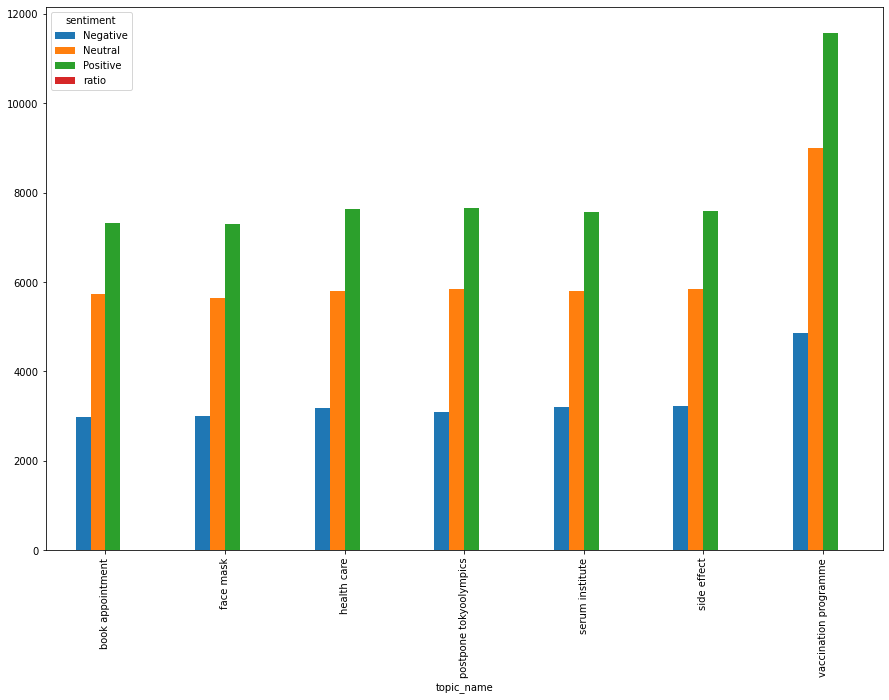

In [ ]:
fig = graph_results.plot.bar(rot=90, figsize=(15,10))
fig.figure.savefig('sentiment_analysis.png', bbox_inches='tight')

In [ ]:
encoding = {1.0: 'vaccination programme',
            2.0: 'postpone tokyoolympics',
            3.0: 'side effect',
            4.0: 'serum institute',
            5.0: 'face mask',
            6.0: 'health care',
            7.0: 'book appointment'
           }

df.replace(encoding, inplace= True)
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,sentiment,sentiment score,tokenise,remove_stopwords,postags,req_words,lemmatise,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Dominant_topic
880,AJ Love,United States,How is today a reflection of yesterday's life ...,13-03-2020 08:20,15,145,1268,False,2020-12-08,"They removed the #CFO #chiefFinancialOfficer, ...","['CFO', 'chiefFinancialOfficer', 'moneytransfe...",Twitter for Android,False,they removed the cfo chieffinancialofficer i w...,Neutral,0.0000,"[they, removed, the, cfo, chieffinancialoffice...","[removed, cfo, chieffinancialofficer, wonder, ...","[(removed, VBN), (cfo, JJ), (chieffinancialoff...","[chieffinancialofficer, wonder, making, moneyt...","[chieffinancialofficer, wonder, making, moneyt...",0.04,0.79,0.04,0.04,0.04,0.04,0.04,postpone tokyoolympics
881,Darkly Dangerous,United States,#sexualassaultsurvivor! \na southern belle wit...,12-10-2013 16:15,312,1730,1767,False,2020-12-08,The ones trusting #Gates &amp; #Fauci &amp; fo...,"['Gates', 'Fauci']",Twitter for Android,False,the ones trusting gates amp fauci amp for mand...,Positive,0.6808,"[the, ones, trusting, gates, amp, fauci, amp, ...","[trusting, gates, fauci, mandates, yall, bette...","[(trusting, VBG), (gates, NNS), (fauci, VBP), ...","[trusting, gates, mandates, sacrifice]","[trusting, gate, mandate, sacrifice]",0.07,0.07,0.07,0.07,0.07,0.07,0.57,book appointment
882,Thailand Medical News,Thailand,A trusted source for all your medical and life...,06-11-2018 13:04,2231,vaccination programme,2772,False,2020-12-08,COVID-19 Vaccine: Washington University’s Gene...,NaN,Twitter Web App,False,covid 19 vaccine washington university s genet...,Positive,0.3182,"[covid, 19, vaccine, washington, university, s...","[19, washington, university, genetically, modi...","[(19, CD), (washington, NN), (university, NN),...","[washington, university, virus, promise, mice,...","[washington, university, virus, promise, mouse...",0.02,0.02,0.02,0.02,0.02,0.02,0.89,book appointment
883,Ashwani Kumar | अश्वनी कुमार | 🇮🇳,India,"Believer, Optimist and a Passionate Adventure ...",31-07-2015 06:01,44,135,170,False,2020-12-08,Putin's daughter vaccinated with the first app...,NaN,Twitter for Android,False,putin s daughter vaccinated with the first app...,Positive,0.4215,"[putin, s, daughter, vaccinated, with, the, fi...","[putin, daughter, vaccinated, approved, planet...","[(putin, NN), (daughter, NN), (vaccinated, VBD...","[putin, daughter, vaccinated, reason, question]","[putin, daughter, vaccinated, reason, question]",0.90,0.02,0.02,0.02,0.02,0.02,0.02,vaccination programme
884,Ashwani Kumar | अश्वनी कुमार | 🇮🇳,India,"Believer, Optimist and a Passionate Adventure ...",31-07-2015 06:01,44,135,170,False,2020-12-08,@MarketWatch Putin's daughter vaccinated with ...,NaN,Twitter for Android,False,putin s daughter vaccinated with the 1st appr...,Positive,0.4215,"[putin, s, daughter, vaccinated, with, the, 1s...","[putin, daughter, vaccinated, 1st, approved, p...","[(putin, NN), (daughter, NN), (vaccinated, VBD...","[putin, daughter, vaccinated, planet, reason, qu]","[putin, daughter, vaccinated, planet, reason, qu]",0.04,0.78,0.04,0.04,0.04,0.04,0.04,postpone tokyoolympics


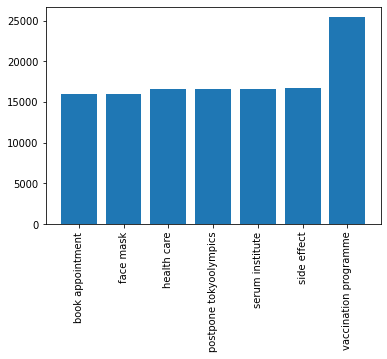

In [ ]:
cnt = df.groupby(['Dominant_topic']).count()
plt.bar(cnt.index, cnt.iloc[:,13])
plt.xticks(rotation = 90)
plt.show()

In [ ]:
tpc1 = tmp[tmp['topic']==1]
tpc2 = tmp[tmp['topic']==2]
tpc3 = tmp[tmp['topic']==3]
tpc4 = tmp[tmp['topic']==4]
tpc5 = tmp[tmp['topic']==5]
tpc6 = tmp[tmp['topic']==6]
tpc7 = tmp[tmp['topic']==7]

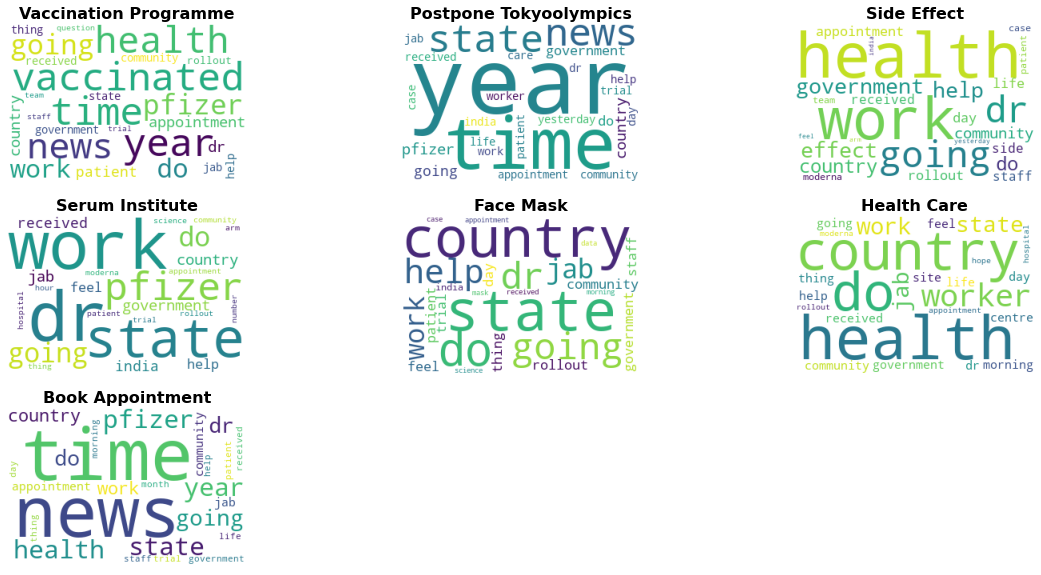

In [ ]:
## topicwise Wordclouds
from wordcloud import WordCloud

string1 = ','.join(list(str(m) for m in tpc1.index))
string2 = ','.join(list(str(m) for m in tpc2.index))
string3 = ','.join(list(str(m) for m in tpc3.index))
string4 = ','.join(list(str(m) for m in tpc4.index))
string5 = ','.join(list(str(m) for m in tpc5.index))
string6 = ','.join(list(str(m) for m in tpc6.index))
string7 = ','.join(list(str(m) for m in tpc7.index))

s1 = ['people', 'vaccination', 'vaccine']
s2 = ['people', 'vaccine', 'vaccination', 'vaccinated', 'health']
s3 = ['people', 'vaccine', 'vaccination', 'vaccinated', 'year', 'time', 'news', 'pfizer', 'state']
s4 = ['people', 'vaccine', 'vaccination', 'vaccinated', 'year', 'time', 'news', 'health']
s5 = ['people', 'vaccine', 'vaccination', 'vaccinated', 'year', 'time', 'news', 'pfizer', 'health']
s6 = ['people', 'vaccine', 'vaccination', 'vaccinated', 'year', 'time', 'news','pfizer']
s7 = ['people', 'vaccine', 'vaccination', 'vaccinated']

w1 = WordCloud(width=300, height=200, max_words=25, background_color='white', stopwords=s1, contour_width=3, collocations = False).generate(string1)
w2 = WordCloud(width=300, height=200, max_words=25, background_color='white', stopwords=s2, contour_width=3, collocations = False).generate(string2)
w3 = WordCloud(width=300, height=200, max_words=25, background_color='white', stopwords=s3, contour_width=3, collocations = False).generate(string3)
w4 = WordCloud(width=300, height=200, max_words=25, background_color='white', stopwords=s4, contour_width=3, collocations = False).generate(string4)
w5 = WordCloud(width=300, height=200, max_words=25, background_color='white', stopwords=s5, contour_width=3, collocations = False).generate(string5)
w6 = WordCloud(width=300, height=200, max_words=25, background_color='white', stopwords=s6, contour_width=3, collocations = False).generate(string6)
w7 = WordCloud(width=300, height=200, max_words=25, background_color='white', stopwords=s7, contour_width=3, collocations = False).generate(string7)

plt.figure(figsize=(20,10))

plt.subplot(3,3,1)
t1 = all_topics.loc[all_topics['Dominant_topic'] == 1, 'topic_name'].iloc[0]
plt.title('Vaccination Programme',fontsize=16,fontweight='bold')
plt.imshow(w1)
plt.axis('off')

plt.subplot(3,3,2)
t2 = all_topics.loc[all_topics['Dominant_topic'] == 2, 'topic_name'].iloc[0]
plt.title('Postpone Tokyoolympics',fontsize=16,fontweight='bold')
plt.imshow(w2)
plt.axis('off')

plt.subplot(3,3,3)
t3 = all_topics.loc[all_topics['Dominant_topic'] == 3, 'topic_name'].iloc[0]
plt.title('Side Effect',fontsize=16,fontweight='bold')
plt.imshow(w3)
plt.axis('off')

plt.subplot(3,3,4)
t4 = all_topics.loc[all_topics['Dominant_topic'] == 4, 'topic_name'].iloc[0]
plt.title('Serum Institute',fontsize=16,fontweight='bold')
plt.imshow(w4)
plt.axis('off')

plt.subplot(3,3,5)
t5 = all_topics.loc[all_topics['Dominant_topic'] == 5, 'topic_name'].iloc[0]
plt.title('Face Mask',fontsize=16,fontweight='bold')
plt.imshow(w5)
plt.axis('off')

plt.subplot(3,3,6)
t6 = all_topics.loc[all_topics['Dominant_topic'] == 6, 'topic_name'].iloc[0]
plt.title('Health Care',fontsize=16,fontweight='bold')
plt.imshow(w6)
plt.axis('off')

plt.subplot(3,3,7)
t7 = all_topics.loc[all_topics['Dominant_topic'] == 7, 'topic_name'].iloc[0]
plt.title('Book Appointment',fontsize=16,fontweight='bold')
plt.imshow(w7)
plt.axis('off')

plt.savefig("/content/drive/MyDrive/NLP_Project/f3.jpg")